<a href="https://colab.research.google.com/github/realshantanu/iMoisture-Backend/blob/main/notebooks/SoilPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class cfg:
    IMAGE_SIZE = 128

    # Train-Val Split
    TRAIN_VAL_SPLIT = 0.8 # 80% of all the samples are used for training, and the rest for validation

    # Model Training
    BATCH_SIZE = 8
    EPOCHS = 20
    LEARNING_RATE = 0.00008

In [ ]:
path = "/content/drive/MyDrive/env/Dataset"

In [ ]:
trainData_path = path + "/Train"
testData_path = path + "/test"

In [ ]:
from tqdm import tqdm
import random
import os
import time

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
tf.random.set_seed(100)
np.random.seed(100)

In [ ]:
data_directories = [testData_path, trainData_path] #dataset

all_paths = []
all_labels = []

for data_dir in data_directories:
    for label in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir, label)):
            all_paths.append(os.path.join(data_dir, label, image))
            all_labels.append(label)

all_paths, all_labels = shuffle(all_paths, all_labels)

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df

path  \
0         /content/drive/MyDrive/env/Dataset/Train/Clay soil/Copy of drought-964339_1920.jpg   
1                         /content/drive/MyDrive/env/Dataset/Train/Clay soil/Sample3.120.jpg   
2                  /content/drive/MyDrive/env/Dataset/Train/Red soil/Copy of Sample6.150.jpg   
3       /content/drive/MyDrive/env/Dataset/Train/Black Soil/Copy of Copy of images435(1).jpg   
4     /content/drive/MyDrive/env/Dataset/Train/Alluvial soil/Copy of IMG-20220531-WA0057.jpg   
...                                                                                      ...   
1550               /content/drive/MyDrive/env/Dataset/test/Clay soil/Copy of images43(1).jpg   
1551                                 /content/drive/MyDrive/env/Dataset/Train/Red soil/3.jpg   
1552                /content/drive/MyDrive/env/Dataset/test/Black Soil/Copy of images394.jpg   
1553               /content/drive/MyDrive/env/Dataset/Train/Black Soil/Copy of images427.jpg   
1554    /content/drive/MyDrive/env/Dataset/Train/Alluvial soil/photo_2022-06-01_07-10-17.jpg   

              label  
0         Clay soil  
1         Clay soil  
2          Red soil  
3        Black Soil  
4     Alluvial soil  
...             ...  
1550      Clay soil  
1551       Red soil  
1552     Black Soil  
1553     Black Soil  
1554  Alluvial soil  

[1555 rows x 2 columns]

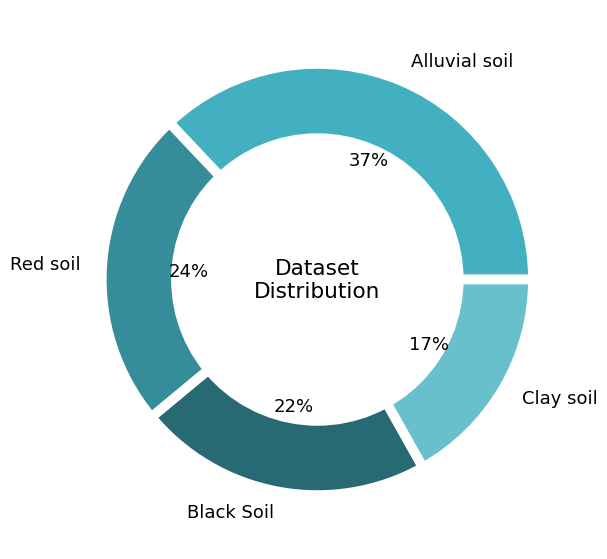

In [ ]:
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(7,7))

# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Dataset\nDistribution', x=0.5, y=0.45)
plt.show()

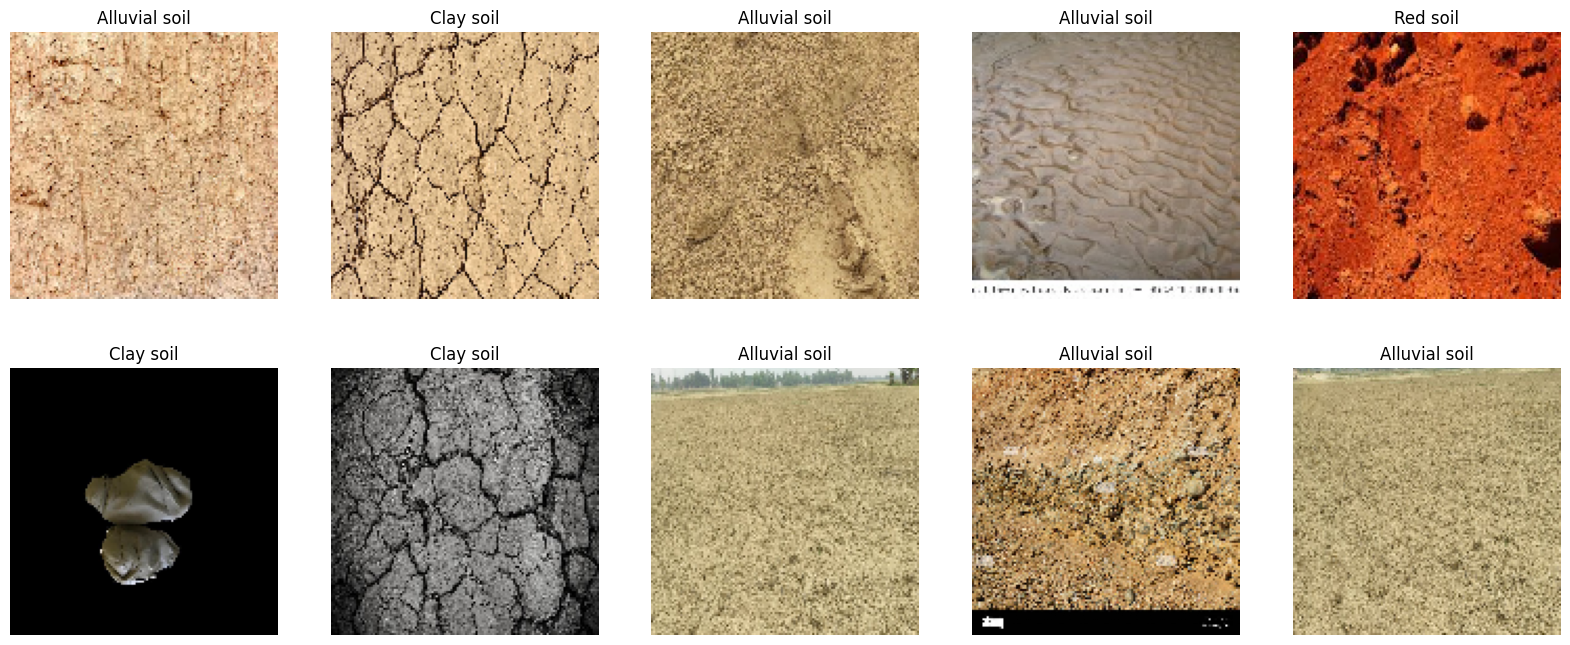

In [ ]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(cfg.IMAGE_SIZE,cfg.IMAGE_SIZE))
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

k = random.randint(0,1000)
image_paths = list(df.path[k:k+10])
labels = list(df.label[k:k+10])
images = open_images(image_paths)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LABELS = ["Red soil", "Black Soil", "Clay soil", "Alluvial soil"]

label_encoder = {label: idx for idx, label in enumerate(LABELS)}
label_decoder = {idx: label for idx, label in enumerate(LABELS)}
label_encoder, label_decoder

({'Red soil': 0, 'Black Soil': 1, 'Clay soil': 2, 'Alluvial soil': 3},
 {0: 'Red soil', 1: 'Black Soil', 2: 'Clay soil', 3: 'Alluvial soil'})

In [ ]:
df_train = df[:int(cfg.TRAIN_VAL_SPLIT*len(df))]
df_val = df[int(cfg.TRAIN_VAL_SPLIT*len(df)):]

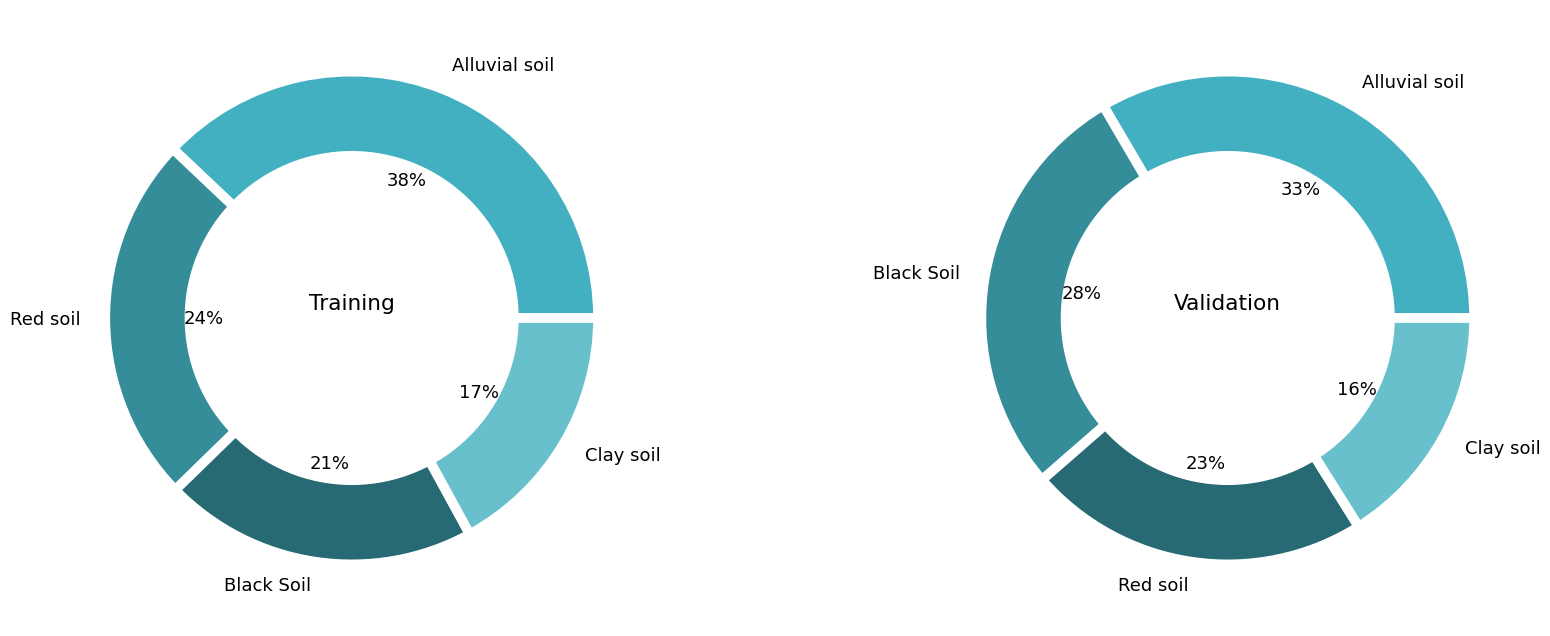

In [ ]:
plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 2, 1)
plt.pie(list(df_train.label.value_counts()),
        labels=list(df_train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5)

fig.add_subplot(1, 2, 2)
plt.pie(list(df_val.label.value_counts()),
        labels=list(df_val.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5)

plt.subplots_adjust(wspace=0.3)
plt.show()


In [ ]:
def data_generator(df, batch_size=cfg.BATCH_SIZE, augment=True, epochs=cfg.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [ ]:
train_data_generator = data_generator(df_train, batch_size=cfg.BATCH_SIZE, epochs=cfg.EPOCHS)
train_steps = int(len(df_train)/cfg.BATCH_SIZE)

val_data_generator = data_generator(df_val, batch_size=cfg.BATCH_SIZE, epochs=cfg.EPOCHS)
val_steps = int(len(df_val)/cfg.BATCH_SIZE)

In [ ]:
model = models.Sequential(name='classifier')
model.add(layers.Input(shape=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3), name='input'))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv1'))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool1'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv1'))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool2'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv1'))
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv2'))
model.add(layers.MaxPool2D(pool_size=(2,2), name='pool3'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dropout(0.3, name='dropout1'))
model.add(layers.Dense(128, activation='relu', name='dense1'))
model.add(layers.Dense(7, activation='softmax', name='final'))

model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 32)      896       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 32)      9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 64)        18496     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 128)       7

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 32)      896       
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 32)      9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 64)        18496     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 128)       7

In [ ]:
class_weights = (df_train.label.value_counts() / len(df_train)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights


{3: 0.37942122186495175,
 0: 0.24356913183279744,
 1: 0.20659163987138263,
 2: 0.17041800643086816}

In [ ]:
history = model.fit(train_data_generator, epochs=cfg.EPOCHS, steps_per_epoch=train_steps, class_weight = class_weights,
                    validation_data=val_data_generator, validation_steps=val_steps)

Epoch 1/20
155/155 [==============================] - 606s 4s/step - loss: 0.2283 - accuracy: 0.5944 - val_loss: 0.6027 - val_accuracy: 0.7697
Epoch 2/20
155/155 [==============================] - 89s 579ms/step - loss: 0.1315 - accuracy: 0.7694 - val_loss: 0.4282 - val_accuracy: 0.8388
Epoch 3/20
155/155 [==============================] - 91s 589ms/step - loss: 0.1013 - accuracy: 0.8188 - val_loss: 0.4021 - val_accuracy: 0.8350
Epoch 4/20
155/155 [==============================] - 95s 612ms/step - loss: 0.0880 - accuracy: 0.8301 - val_loss: 0.3567 - val_accuracy: 0.8350
Epoch 5/20
155/155 [==============================] - 91s 587ms/step - loss: 0.0735 - accuracy: 0.8657 - val_loss: 0.3078 - val_accuracy: 0.8680
Epoch 6/20
155/155 [==============================] - 91s 588ms/step - loss: 0.0647 - accuracy: 0.8964 - val_loss: 0.2990 - val_accuracy: 0.8911
Epoch 7/20
155/155 [==============================] - 91s 586ms/step - loss: 0.0602 - accuracy: 0.9053 - val_loss: 0.2861 - val_accu

155/155 [==============================] - 90s 584ms/step - loss: 0.0092 - accuracy: 0.9879 - val_loss: 0.1191 - val_accuracy: 0.9820


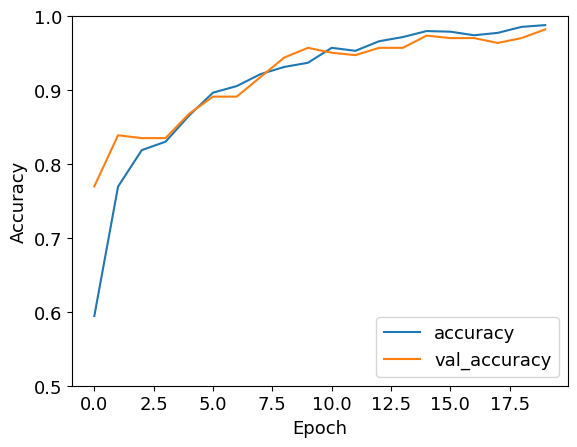

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
model.save('soil_classification_model.keras')

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Load the model
model = load_model('soil_classification_model(1).h5')

# Load the image
new_data = '/content/10.jpeg'
img = Image.open(new_data)

# Resize the image
resized_img = img.resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))

# Convert the image to a numpy array
resized_img_array = np.array(resized_img)
# Reshape the image to a single sample
resized_img_array = resized_img_array.reshape(-1, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 3)

# Make predictions
predictions = model.predict(resized_img_array)

# Print the predictions
print(label_decoder[np.argmax(predictions)])

1/1 [==============================] - 2s 2s/step


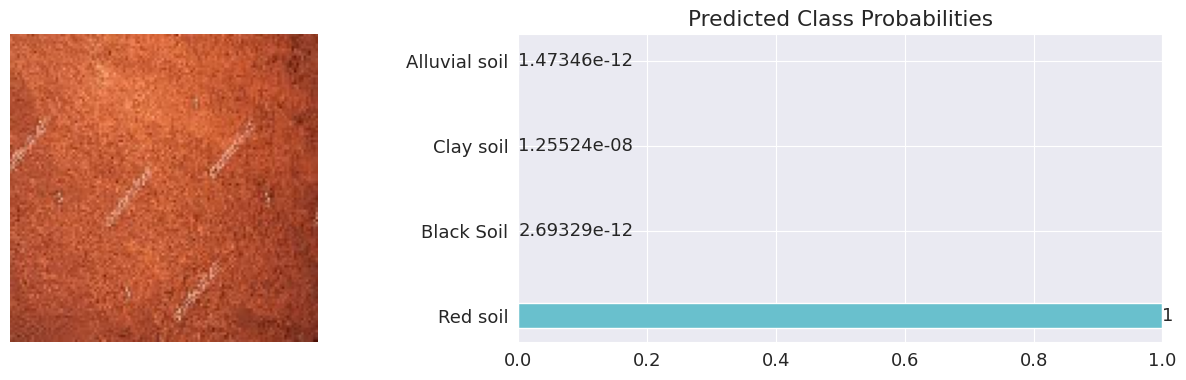

Actual   : Red soil
Predicted: Red soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 87ms/step


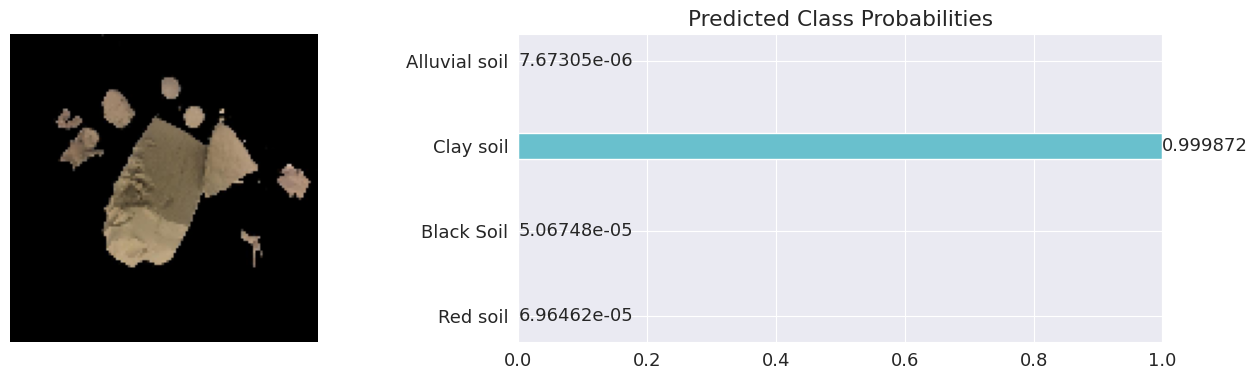

Actual   : Clay soil
Predicted: Clay soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 87ms/step


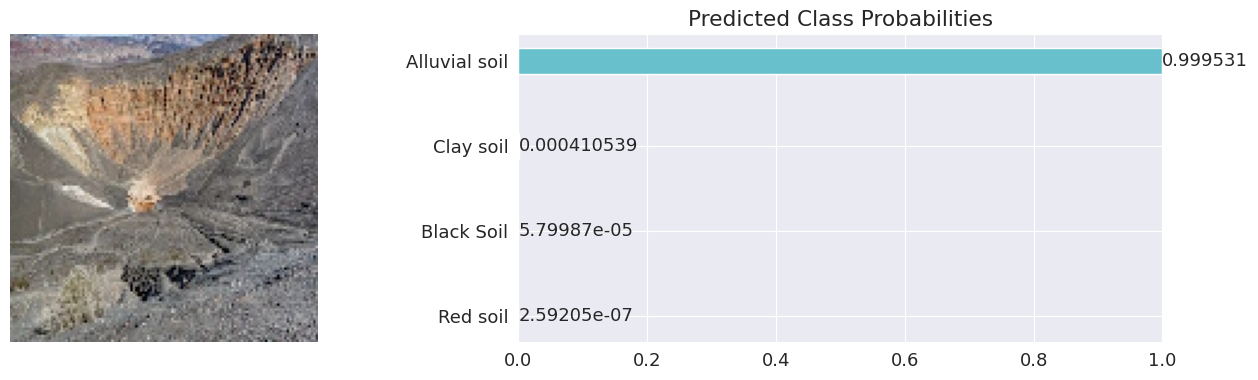

Actual   : Alluvial soil
Predicted: Alluvial soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 85ms/step


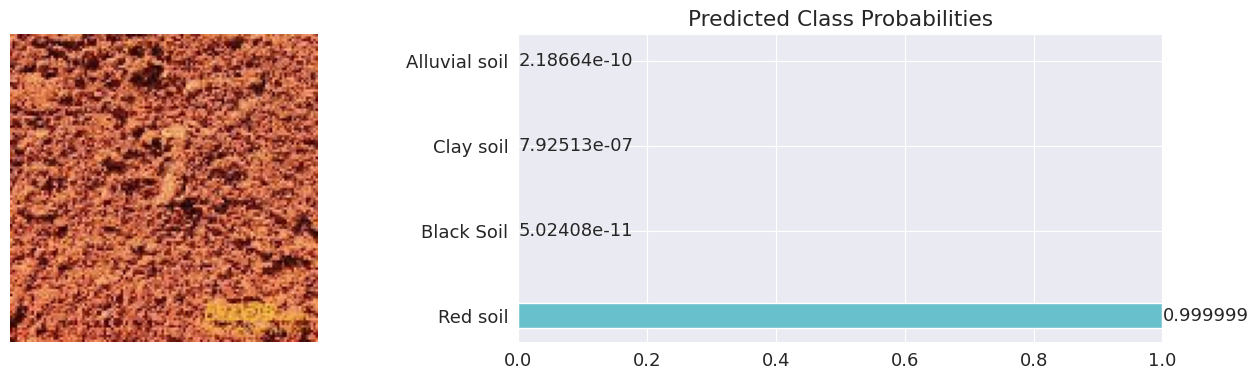

Actual   : Red soil
Predicted: Red soil
--------------------------------------------------------------------------------




1/1 [==============================] - 0s 93ms/step


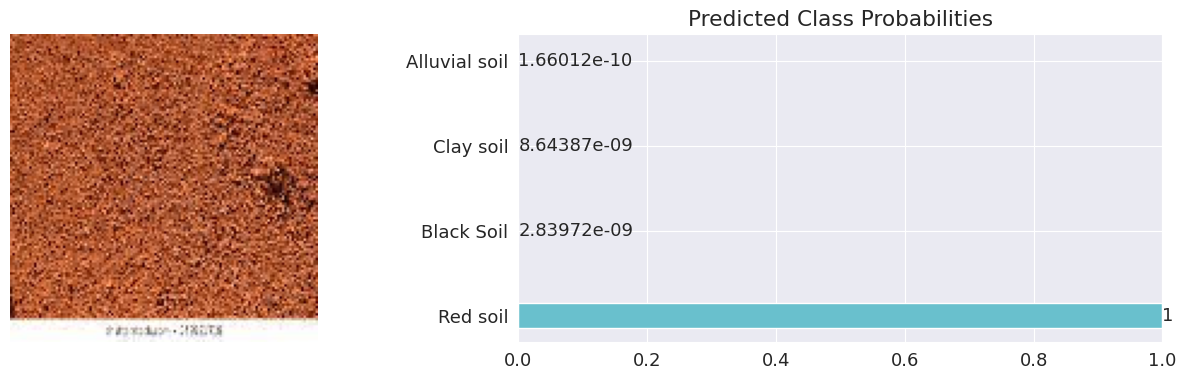

Actual   : Red soil
Predicted: Red soil
--------------------------------------------------------------------------------




1/1 [==============================] - 0s 98ms/step


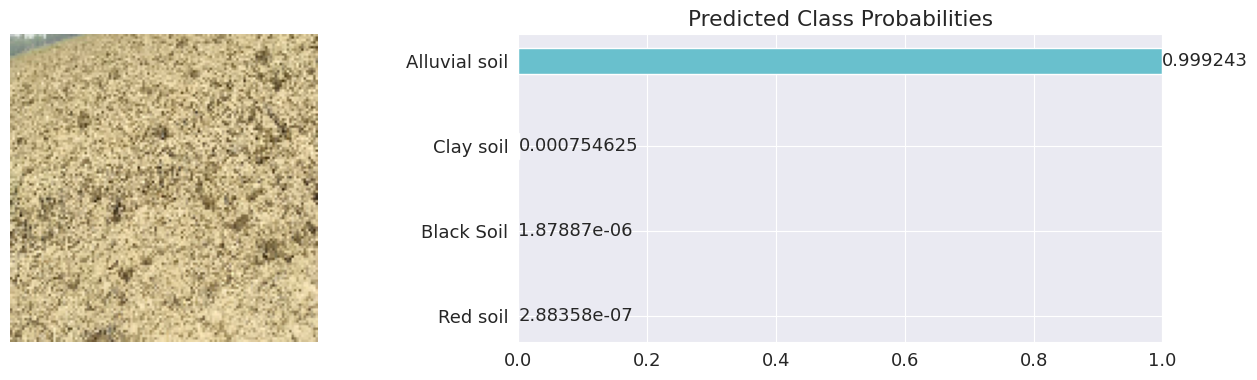

Actual   : Alluvial soil
Predicted: Alluvial soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 88ms/step


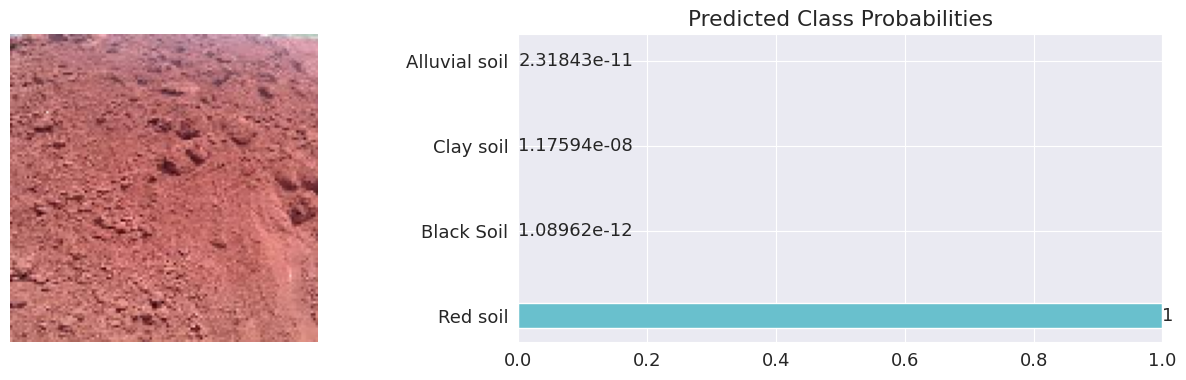

Actual   : Red soil
Predicted: Red soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 89ms/step


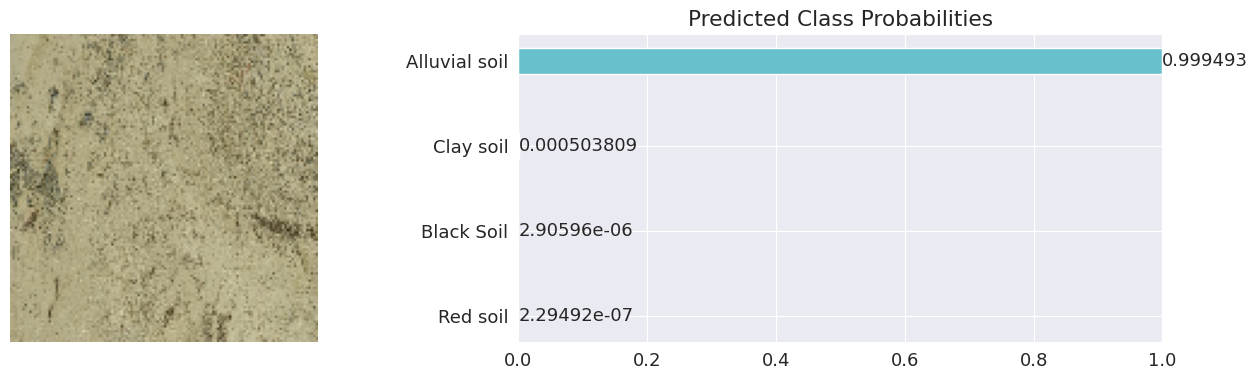

Actual   : Alluvial soil
Predicted: Alluvial soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 132ms/step


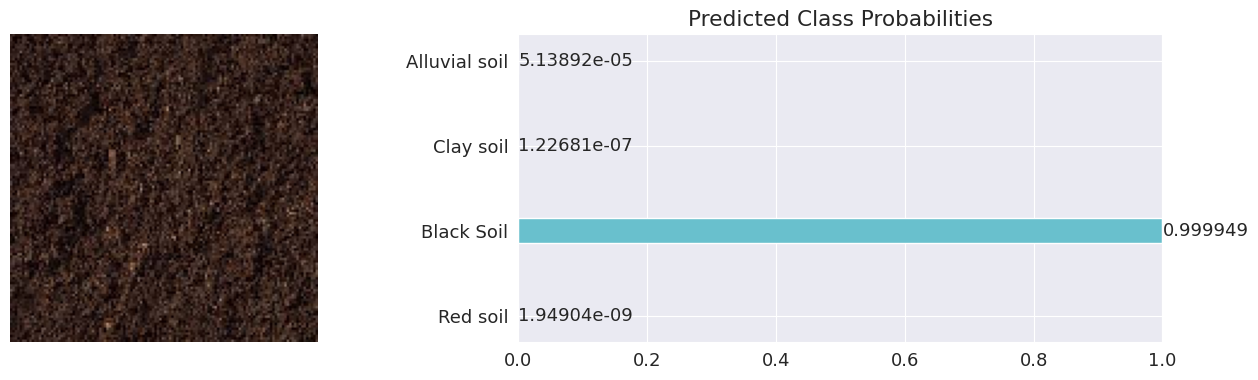

Actual   : Black Soil
Predicted: Black Soil
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 137ms/step


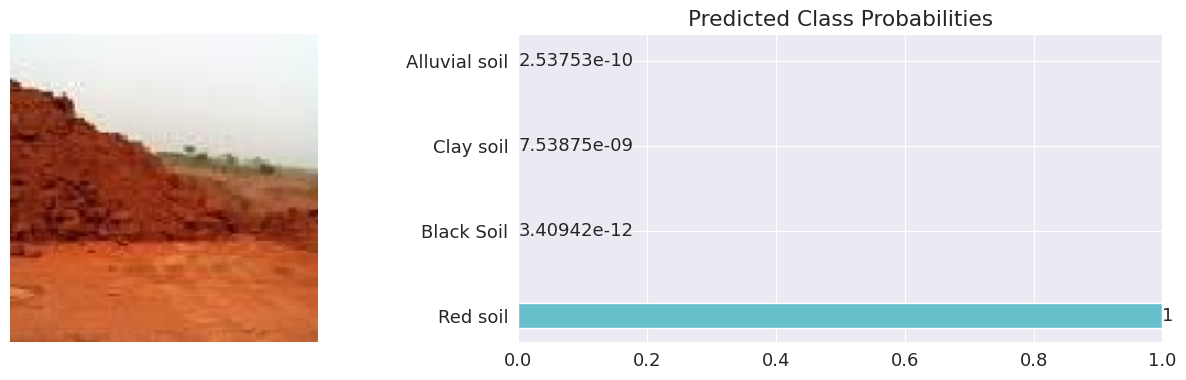

Actual   : Red soil
Predicted: Red soil
--------------------------------------------------------------------------------




In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels = ['Red soil', 'Black Soil', 'Clay soil', 'Alluvial soil']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,cfg.IMAGE_SIZE,cfg.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(df_val.index), 10)

for INDEX in INDICES:

    image = load_img(df_val.path[INDEX], target_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
    model = load_model('soil_classification_model(1).h5')
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)

    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')


# New Section

In [ ]:
import tensorflow as tf
import os

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = '/content/drive/MyDrive/soilmoisture'
image_exts = ['jpeg','jpg', 'bmp', 'png']
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
  if not os.path.isdir(image_class):  # Check if it's a directory, not a file
    continue

  for image in os.listdir(os.path.join(data_dir, image_class)):
    if image == '.DS_Store':
      pass

    image_path = os.path.join(data_dir, image_class, image)
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
    except Exception as e:
        print('Issue with image {}'.format(image_path))
        # os.remove(image_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# tf.data.Dataset??

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 272 files belonging to 9 classes.


In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([7, 6, 1, 6, 3, 8, 1, 6, 3, 5, 1, 5, 4, 4, 6, 1, 3, 1, 3, 4, 0, 1,
       3, 5, 2, 1, 1, 3, 1, 0, 0, 6], dtype=int32)

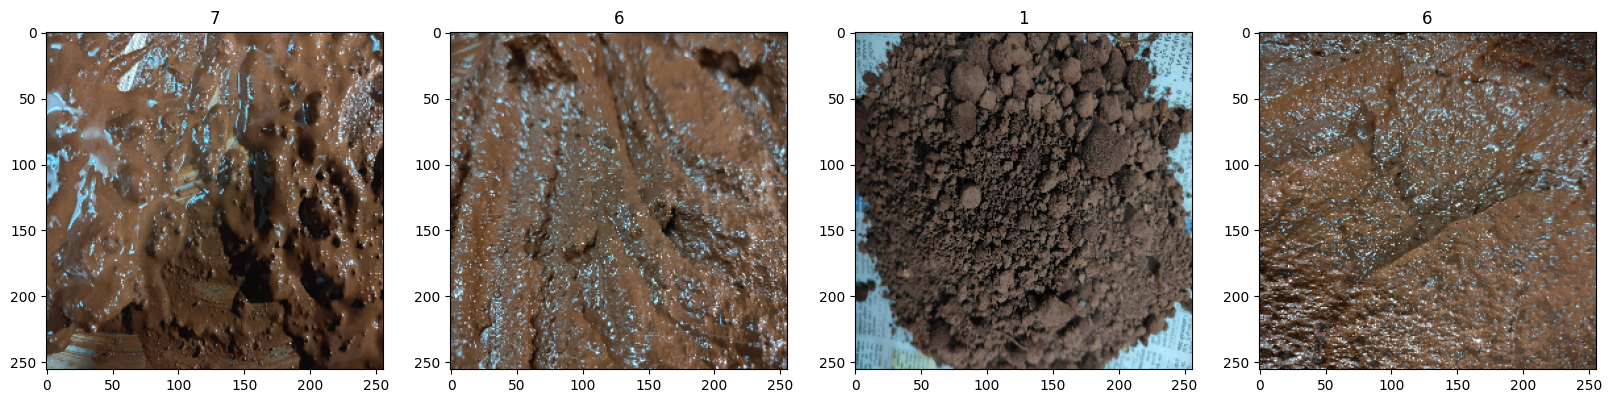

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
# data.as_numpy_iterator().next()

In [ ]:
data_iterator_scaled = data.as_numpy_iterator()
batch = data_iterator_scaled.next()

In [ ]:
len(data)

9

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
train_size+test_size+val_size

9

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='sigmoid'))

In [ ]:
# prompt: write model.compile for multi classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [ ]:
logs = '/content/logs'


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs)


In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 87s 10s/step - loss: 2.5366 - accuracy: 0.1302 - val_loss: 2.2565 - val_accuracy: 0.0938
Epoch 2/20
6/6 [==============================] - 84s 10s/step - loss: 2.1512 - accuracy: 0.1406 - val_loss: 2.1091 - val_accuracy: 0.1406
Epoch 3/20
6/6 [==============================] - 85s 10s/step - loss: 2.0375 - accuracy: 0.1875 - val_loss: 2.0447 - val_accuracy: 0.1719
Epoch 4/20
6/6 [==============================] - 86s 10s/step - loss: 1.9049 - accuracy: 0.3177 - val_loss: 1.8251 - val_accuracy: 0.2969
Epoch 5/20
6/6 [==============================] - 87s 10s/step - loss: 1.5531 - accuracy: 0.4375 - val_loss: 1.1947 - val_accuracy: 0.6875
Epoch 6/20
6/6 [==============================] - 85s 10s/step - loss: 1.1863 - accuracy: 0.5573 - val_loss: 1.1531 - val_accuracy: 0.4844
Epoch 7/20
6/6 [==============================] - 84s 10s/step - loss: 0.9887 - accuracy: 0.6042 - val_loss: 0.8737 - val_accuracy: 0.7812
Epoch 8/20
6/6 [===========

In [ ]:
model.save('soilmoisture.keras')
model.save('soilmoisture1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


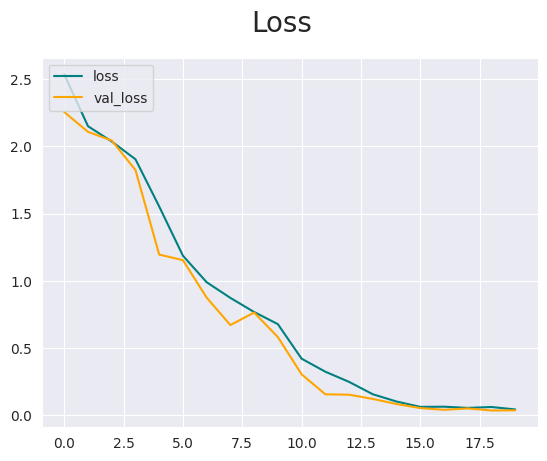

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

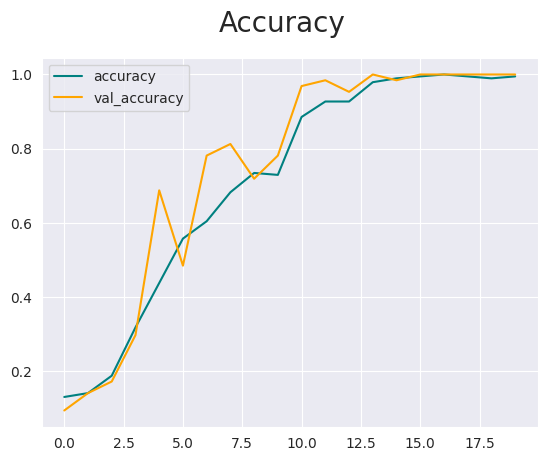

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
import cv2

ValueError: 'rgb' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

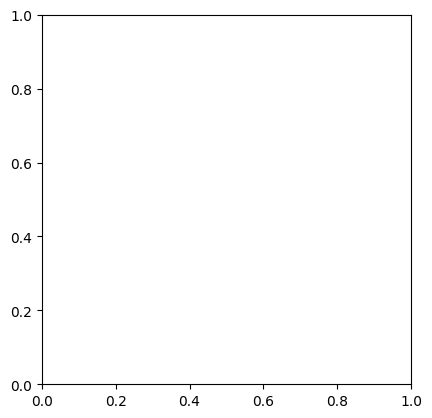

In [ ]:
img = cv2.imread('/content/drive/MyDrive/soilmoisture/0/WhatsApp Image 2024-02-14 at 19.09.25 (1).jpeg')
img2 = cv2.imread('/content/drive/MyDrive/soilmoisture/50/WhatsApp Image 2024-02-16 at 22.55.53 (2).jpeg')
plt.imshow(img, cmap = 'rgb')
print(type(img))
plt.show()

<class 'tensorflow.python.framework.ops.EagerTensor'>


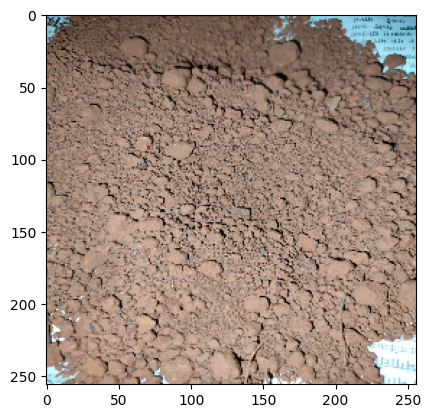

In [ ]:
resize = tf.image.resize(img, (256,256))
print(type(resize))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 61ms/step


In [ ]:
# yhat

In [ ]:
labed_decoder1 = {0: '0',
  1: '10',
  2: '20',
  3: '30',
  4: '40',
  5: '50',
  6: '60',
  7: '70',
  8: '80'}


In [ ]:
labed_decoder1

{0: '0',
 1: '10',
 2: '20',
 3: '30',
 4: '40',
 5: '50',
 6: '60',
 7: '70',
 8: '80'}

In [ ]:
# prompt: use labed_decoder1 to find class for the prediction yhat

import numpy as np
print(labed_decoder1[np.argmax(yhat)])


50
